# Turn it into a Toon!!!

The basic idea is to transform the dataset into images that anyone can use with a typical AI vision pipeline.
There are 287 characteristics, and we can create an image of 17x17, which is 289 characteristics and create a new 'noisy' image dataset [Bacteria images TPS Feb 22](https://www.kaggle.com/austinpowers/bacteria-images-tps-feb-22)

The intention of this notebook is:

* to provide the code for generating the new dataset
* to provide the code for generating the new images
* to extend the EDA to gain more insights 

Have fun! :-)

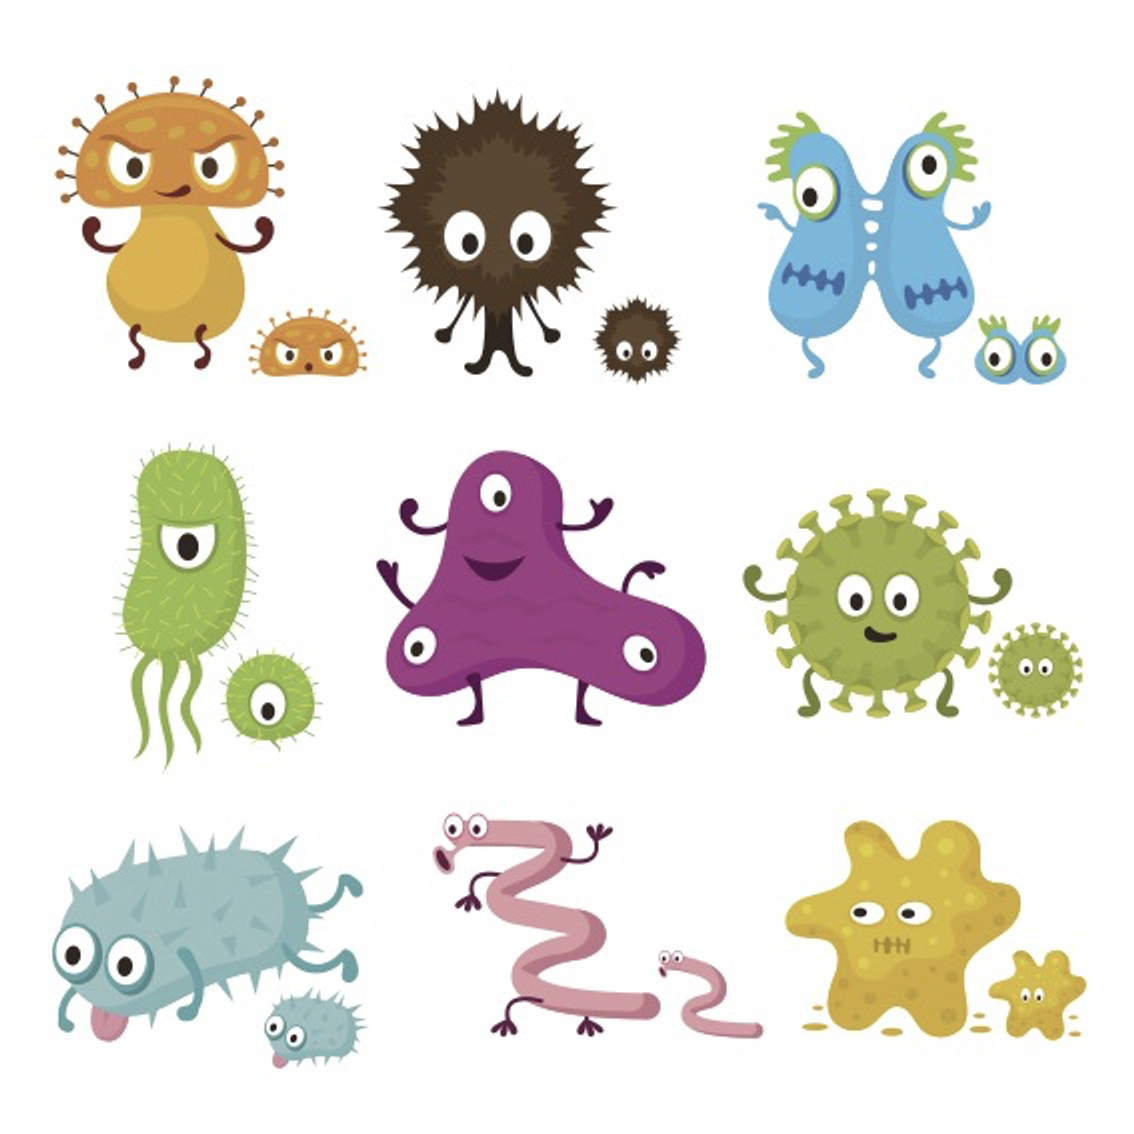

You are probably looking for additional external datasets. I'm happy to share my notebook for new data generation. So here it is. ;-) 

It's very likely that I will work on this notebook in a few days to expand the EDA and the models. Stay tuned! ;-)


## <div style="color:white;display:fill;border-radius:5px;background-color:#e3b663;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:black;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> There is a new notebook called [Turn it into a Toon!!! TPS Feb 22 FastAI Model](https://www.kaggle.com/austinpowers/turn-it-into-a-toon-tps-feb-22-fastai-model) with expanded EDA and a vision FastAI model XResNet18 and a [discussion](https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion/305343#1676305) about this notebook</p></div>


## <div style="color:white;display:fill;border-radius:5px;background-color:#e3b663;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:black;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> If you like the content or the idea, please consider support the work with an upvote👍</p></div>


# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="TOC"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Table of contents</p></div>

0. [Install](#Install)
1. [Imports](#Imports)
2. [Dataset](#Dataset) 
3. [Rescale the dataset](#Rescale)
4. [Compute the RGB color values](#Compute) 
5. [Visualize ten samples](#Visualize)
6. [Create the new dataset](#Create)
7. [Save the new dataset](#Save)
8. [Load the new dataset](#Load)

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Install"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Install</p></div>
[back](#TOC)

In [ ]:
#!pip install google-cloud-bigquery-storage

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.all import *


# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Imports"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Imports</p></div>
[back](#TOC)



In [ ]:
## Basic packages
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
sns.set_style('whitegrid')
from sklearn.preprocessing import MinMaxScaler
plt.rc('image', cmap='Greys')
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 8)

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Dataset"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Dataset</p></div>
[back](#TOC)


We just import the train and test dataset.

In [ ]:
#import data into pandas DataFrames
train = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv', index_col = 'row_id')
test = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv', index_col = 'row_id')

In [ ]:
train

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Rescale"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Rescale the dataset</p></div>
[back](#TOC)



To highlight all the features, we need to rescale the dataset between 0 and 256x256x256.
I initially used MinMaxScaler from sklearn, but I could not make it work on every single column because, by default, it scales the whole data frame.
So I opted for a manual approach, and I built the function to have every column scaled between zero and 16.7 million.

In [ ]:
#scaler = MinMaxScaler(feature_range=(0, float(256**3)))
#train_scaled = pd.DataFrame(scaler.fit_transform(train.drop(columns='target')), columns=train.drop(columns='target').columns)


In [ ]:
cols = train.columns[0:-1]
train_scaled=pd.DataFrame(columns=cols)

for i in range(len(cols)):
    df = train[cols[i]]
    df_scaled = (df-df.min())/(df.max()-df.min())*(256**3)
    train_scaled[cols[i]] = df_scaled
    
train_scaled.describe()


Here we can see that after scaling every single column ranges between **zero** and **16.7mln**.

In [ ]:
train_scaled

Now we have 286 columns, but we need 289 to create our image of 17x17, so we add the three missing columns with zeros.
We also add the 'target' column at the end of the dataframe.

In [ ]:
#add two columns to have a squared picture 17x17 = 289 --- CHECK NUMBERS
train_scaled['man_insert1'] = float(0)
train_scaled['man_insert2'] = float(0)
train_scaled['man_insert3'] = float(0)

#add the target column
train_scaled['target'] = train['target']


In [ ]:
train_scaled.sample()

We need to rescale the test dataset as well

In [ ]:
cols = test.columns
test_scaled=pd.DataFrame(columns=cols)

for i in range(len(cols)):
    df = test[cols[i]]
    df_scaled = (df-df.min())/(df.max()-df.min())*(256**3)
    test_scaled[cols[i]] = df_scaled

    #add three columns to have a squared picture 17x17 = 289 --- CHECK NUMBERS
test_scaled['man_insert1'] = float(0)
test_scaled['man_insert2'] = float(0)
test_scaled['man_insert3'] = float(0)

print(test_scaled.shape)


# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Compute"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Compute the RGB color values</p></div>
[back](#TOC)



to compute the RGB colors is pretty straightforward.
We have the LONG number that we previuosly computed and we apply the three formulas reported below:


 **Convert LONG to RGB:**

Blue value:
 B = LONG \ 65536
 
Green value:
G = (LONG - B * 65536) \ 256
 
Red value:
R = LONG - B * 65536 - G * 256
 
 
 
 The reverse computation is
 
**Convert RGB to LONG:**

 LONG = B * 65536 + G * 256 + R
 
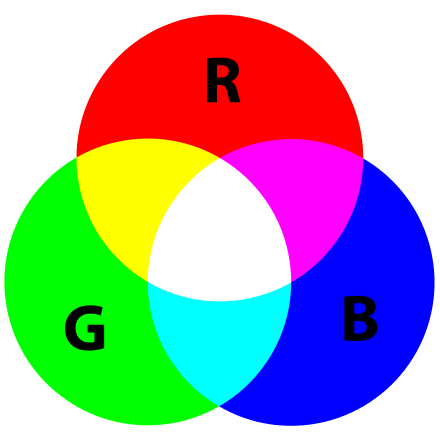
 
 

Create a tensor from a single sample in the dataframe

In [ ]:
arr = tensor((train_scaled.iloc[1,0:289]).astype(np.float))
arr

Reshape it, just to give the idea, into a tensor 17x17.

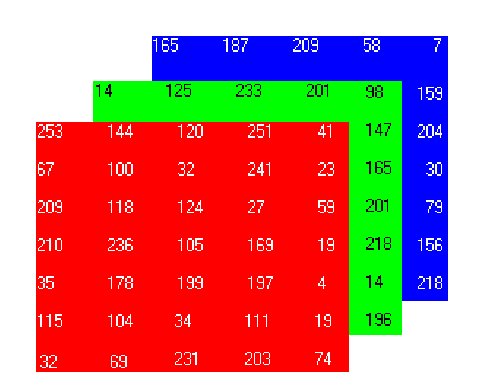

In [ ]:
Long1 = torch.reshape(arr,(17,17))
Long1.shape

Compute the matrix of Blue color

In [ ]:

Blue1 = (Long1/65536).int()
Blue1

And we visualize it

In [ ]:
def bluepic(img):
  df = pd.DataFrame(img)
  return df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

In [ ]:
bluepic(Blue1)

In [ ]:
#green = (LONG - B * 65536) \ 256
Green1 = ((Long1 - Blue1 * 65536)/256).int()
Green1

In [ ]:
def greenpic(img):
  df = pd.DataFrame(img)
  return df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greens')

In [ ]:
greenpic(Green1)

In [ ]:
#R = LONG - B * 65536 - G * 256
Red1 = (Long1 - Blue1 *65536 - Green1 * 256).int()
Red1

In [ ]:
def redpic(img):
  df = pd.DataFrame(img)
  return df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Reds')

In [ ]:
redpic(Red1)

In [ ]:
def bigpic(img):
  df = pd.DataFrame(img)
  return df.style.set_properties(**{'font-size':'6pt'}).background_gradient('gist_rainbow')
bigpic(Long1.int())

In this last image every pixel has the Long number.

In [ ]:
pic = torch.stack((Red1.flatten(),Green1.flatten(),Blue1.flatten()))
pic.shape

In [ ]:
pic = torch.reshape(pic,(3,17,17))

Below the tensor with the three RGB layers

In [ ]:
pic

In [ ]:
pic.shape

To visualize it in pytorch we need to move the channels at the end.
We need a tensor 17,17,3.

In [ ]:
pic = torch.permute(pic, (1, 2, 0))
pic.shape

In [ ]:
img = Image.fromarray(pic.numpy(), 'RGB')

In [ ]:
show_image(img)

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Visualize"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Visualize ten samples</p></div>
[back](#TOC)



We now create a small dataframe with ten samples per each bacteria target just to visualize the work.

In [ ]:
target_values = train_scaled['target'].unique()
samples_df = pd.DataFrame(columns=train_scaled.columns)

for i in range(len(target_values)):
    df_filter = train_scaled[train_scaled['target']==target_values[i]][0:10]
    samples_df = samples_df.append(df_filter)
    
samples_df

We need to process the dataframe with the same steps that we did before, and for this task I created a small method.

In [ ]:
def create_pics(train_scaled):
    
  pic_rgb=[]
  for i in range(len(train_scaled)):
    #cast into float tensor
    arr = tensor((train_scaled.iloc[i,0:289]).astype(np.float))

    #reshape into a picture 17x17
    Long1 = torch.reshape(arr,(17,17))

    #compute RGB channells
    Blue1 = (Long1/65536).int()
    Green1 = ((Long1 - Blue1 * 65536)/256).int()
    Red1 = (Long1 - Blue1 *65536 - Green1 * 256).int()

    #create yeansor image
    pic = torch.stack((Red1.flatten(),Green1.flatten(),Blue1.flatten()))
    pic = torch.reshape(pic,(3,17,17))
    pic = torch.permute(pic, (1, 2, 0))

    pic_rgb.append(pic)

  pic_rgb_t = torch.stack(pic_rgb)

  return pic_rgb_t

In [ ]:
sample_pics = create_pics(samples_df)

we now have 100 pics of size 17x17 with 3 channels RGB

In [ ]:
sample_pics.shape

In [ ]:
fig, ax = plt.subplots(10,10, figsize=(20, 20))

for c in range(10):
    for r in range(10):
        image = sample_pics[c*10+r]
        ax[r, c].imshow(image)
        ax[r, c].set_title(target_values[c])#"Outlier in \n cluster {}".format(cluster))
        ax[r, c].axis("off")

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Create"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Create the new dataset</p></div>
[back](#TOC)



We can finally create the new dataset and save it.

Create the new pictures for the whole dataset

In [ ]:
new_pics_train = create_pics(train_scaled)

In [ ]:
new_pics_train.shape

Now we need to add the labels

In [ ]:
train_y_labels = train['target']

Create the new pictures for the test dataset

In [ ]:
new_pics_test = create_pics(test_scaled)

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Save"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Save the new dataset</p></div>
[back](#TOC)



Here the code to save it, but run it only if you plan to export the dataset.
I can't run it because the notebook doesn't commit if I do it.

In [ ]:
# torch.save(new_pics_train,'./train_X_dset_bacteria')
# torch.save(new_pics_test,'./test_dset_bacteria')

In [ ]:
# train_y_labels.to_csv('./train_y_dset_bacteria.csv')

# <div style="color:white;display:fill;border-radius:5px;background-color:#2ebc24;font-family:DM Serif Display;overflow:hidden"><a class="anchor" id="Load"></a><p style="padding:20px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> Load the new dataset</p></div>
[back](#TOC)



Code to load the saved data.

In [ ]:
#loaded_dset = torch.load('./train_X_dset_bacteria')

In [ ]:
#loaded_dset.shape

In [ ]:
#loaded_train_y = pd.read_csv('./train_y_dset_bacteria.csv',index_col = 'row_id')

In [ ]:
#loaded_train_y

## <div style="color:white;display:fill;border-radius:5px;background-color:#e3b663;font-family:DM Serif Display;overflow:hidden"><p style="padding:20px;color:black;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> If you like the content or the idea, please consider support the work with an upvote👍</p></div>
